# Binomial Test

> Use Case
- Used when dealing with a dichotomous outcome (success/failure) and comparing the proportion of successes between two groups.
-  Useful when the sample size is small (usually n <= 30).
> Assumptions
- The data must be binary (success/failure).
- Each observation must be independent.
> Example Scenario
- Testing whether the click-through rate (CTR) for a new ad campaign is different from the historical CTR (historical success rate).
> Null Hypothesis (H0):
- There is no difference in proportions
- The click-through rate for the new ad campaign is equal to the historical CTR.
> Alternative Hypothesis (H1):
- There is a significant difference in proportions
- The click-through rate for the new ad campaign is different from the historical CTR.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import binomtest, norm, binom

# !pip install statsmodels==0.12.2
from statsmodels.stats.proportion import binom_test

# !pip install pingouin==0.5.4
from pingouin import bayesfactor_binom

/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_57234/3382821559.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/544

In [3]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [4]:
import scipy
scipy.__version__

'1.12.0'

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

In [6]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'salmon'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [7]:
# Historical click-through rate
historical_ctr = 0.1

In [8]:
def binomial_sample_size(p, alpha, confidence_level=0.95):

    # Calculates z-score given confidence level
    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculates sample size with the z-score, estimated proportion, and margin of error
    sample_size = int((z_score**2 * p * (1 - p)) / alpha**2)

    return sample_size

In [9]:
# Replace with your estimated proportion
estimated_proportion = historical_ctr

# Replace with your desired margin of error
alpha = 0.05  

# Replace with your desired confidence level
confidence_level = 0.95  

sample_size = binomial_sample_size(estimated_proportion, alpha, confidence_level)
print(f"Required sample size per group: {sample_size}")

Required sample size per group: 138


### Synthetic Data

In [20]:
# Number of trials for historical CTR and new ad campaign
n_trials = 138

# Generate synthetic data for new ad campaign
# Assuming a slightly higher CTR for the new campaign
new_ad_campaign = np.random.binomial(n=1, p=0.13, size=n_trials)  

# Create pandas data frame
binomial_data = pd.DataFrame({'Historical_CTR': np.random.binomial(n=1, p=historical_ctr, size=n_trials),
                            'New_Ad_Campaign': new_ad_campaign})
binomial_data

,Historical_CTR,New_Ad_Campaign
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
133,0,0
134,0,0
135,0,1
136,0,1


### Check Assumptions

In [21]:
# Assumption check for binomial test
min_successes = 5
min_failures = 5

# Check if there are enough successes and failures
successes_check = (binomial_data['New_Ad_Campaign'].sum() >= min_successes)
failures_check = ((n_trials - binomial_data['New_Ad_Campaign'].sum()) >= min_failures)

# Check if the data is binary
binary_new_check = (binomial_data['New_Ad_Campaign'].isin([0, 1]).all())
binary_historical_check = (binomial_data['Historical_CTR'].isin([0, 1]).all())

print(f"Binomial Test Assumption: At least {min_successes} successes and {min_failures} failures - {'Met' if successes_check and failures_check else 'Not Met'}")
print(f"Binomial Test Assumption: Data is numeric and binary - {'Met' if binary_new_check and binary_historical_check else 'Not Met'}")


Binomial Test Assumption: At least 5 successes and 5 failures - Met
Binomial Test Assumption: Data is numeric and binary - Met


### Binomial Test (scipy)

In [22]:
# Pre-determined alpha
alpha = 0.05

In [23]:
# Assuming binomial test assumptions are met

# Binomial test
result = binomtest(binomial_data['New_Ad_Campaign'].sum(), n_trials, p=historical_ctr)

# p-value
p_value = result.pvalue

print(f"P-value for Binomial Test: {p_value}")

# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis."
    interpretation = "The click-through rate for the new ad campaign is significantly different from the historical CTR."
else:
    conclusion = "Fail to reject the null hypothesis."
    interpretation = "There is no significant difference in click-through rates between the new ad campaign and historical CTR."
print("\n")
print(conclusion)
print(interpretation)

P-value for Binomial Test: 0.4799932077795566


Fail to reject the null hypothesis.
There is no significant difference in click-through rates between the new ad campaign and historical CTR.


### Binomial Test (statsmodels)

In [24]:
# Pre-determined alpha
alpha = 0.05

In [25]:
count = binomial_data['New_Ad_Campaign'].sum()
nobs = len(binomial_data['New_Ad_Campaign'])

binom_test(count =count, nobs=nobs, prop=historical_ctr, alternative='two-sided')

AttributeError: module 'scipy.stats' has no attribute 'binom_test'

# Binomial Test - Bayes Factor (pingouin)

In [45]:
# The number of successes
k = int(binomial_data['New_Ad_Campaign'].sum())
# The number of trials
n = int(binomial_data['New_Ad_Campaign'].count())
# The historical probability
p = historical_ctr
# The alpha shape parameter of the Beta Distribution (a=a and b=1 is an uninformed prior)
a = 1
# The beta shape parameter of the Beta Distribution (a=a and b=1 is an uninformed prior)
b = 1 

# Evaluate Bayes Factor
bf = bayesfactor_binom(k=k, n=n, p=p, a=a, b=b)

print(f"Bayes Factor of the Alternative Hypothesis: {round(bf, 4)}")
print(f"Bayes Factor of the Null Hypothesis: {round(1/bf, 4)}")
print("\n")
if bf > (1/bf):
    print("There is more evidence to support the Alternative Hypothesis, there is a significant difference in proportions")
else:
    print("There is more evidence to support the Null Hypothesis, there is a no significant difference in proportions")



Bayes Factor of the Alternative Hypothesis: 0.0821
Bayes Factor of the Null Hypothesis: 12.1733


The results favor the Null Hypothesis, there more evidence to support that there is a no significant difference in proportions


### Summary Table

In [26]:
# Count everything up
total_count = binomial_data.size
group_a_count = binomial_data['New_Ad_Campaign'].count()
group_b_count = binomial_data['Historical_CTR'].count()

group_a_positive_count = binomial_data['New_Ad_Campaign'].sum()
group_a_negative_count = group_a_count - group_a_positive_count

group_b_positive_count = binomial_data['Historical_CTR'].sum()
group_b_negative_count = group_b_count - group_b_positive_count

group_a_proportion = group_a_positive_count/group_a_count

group_b_proportion = group_b_positive_count/group_b_count

In [27]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A: New Ad Campaign", "Group B: Historical CTR"],
    'Total': [group_a_count, group_b_count],
    'Click': [group_a_positive_count, group_b_positive_count],
    'No Click': [group_a_negative_count, group_b_negative_count],
    'Click Through Rate': [group_a_proportion, group_b_proportion],
}, index=[0, 1])
plot_data

,Test Group,Total,Click,No Click,Click Through Rate
0,Group A: New Ad Campaign,138,16,122,0.115942
1,Group B: Historical CTR,138,22,116,0.159420


### 95% Confidence Interval

In [28]:
# Confidence interval
confidence_interval = 0.95


# Proportions
prop_A = group_a_positive_count / group_a_count
prop_B = group_b_positive_count / group_b_count

# Standard errors
se_A = np.sqrt(prop_A * (1 - prop_A) / group_a_count)
se_B = np.sqrt(prop_B * (1 - prop_B) / group_b_count)

# Difference in proportions
prop_diff = prop_A - prop_B

# Standard error of the difference
se_diff = np.sqrt(se_A**2 + se_B**2)

# Z-score for confidence interval (two-tailed)
z_score = norm.ppf(confidence_interval)

# Margin of error
margin_of_error = z_score * se_diff

# Confidence interval
lower_ci = prop_diff - margin_of_error
upper_ci = prop_diff + margin_of_error

print(f"Difference in Proportions: {prop_diff}")
print(f"95% Confidence Interval of Difference in Proportions: [{lower_ci}, {upper_ci}]")

Difference in Proportions: -0.0434782608695652
95% Confidence Interval of Difference in Proportions: [-0.11157209964296255, 0.024615577903832148]


### Effect Size

In [19]:
# Cohen's h effect size
h = np.arcsin(np.sqrt(prop_A)) - np.arcsin(np.sqrt(prop_B))

print(f"Cohen's h Effect Size: {h}")
print("\n")

if abs(h) == 0:
    print("There is no difference between the two groups.")
elif abs(h) <= 0.2:
    print("There is a small difference between the two groups.")
elif abs(h) <= 0.5:
    print("There is a moderate difference between the two groups.")
elif abs(h) <= 0.8:
    print("There is a large difference between the two groups.")
else:
    print("There is a very large difference between the two groups.")

Cohen's h Effect Size: 0.0


There is no difference between the two groups.


### Visualization

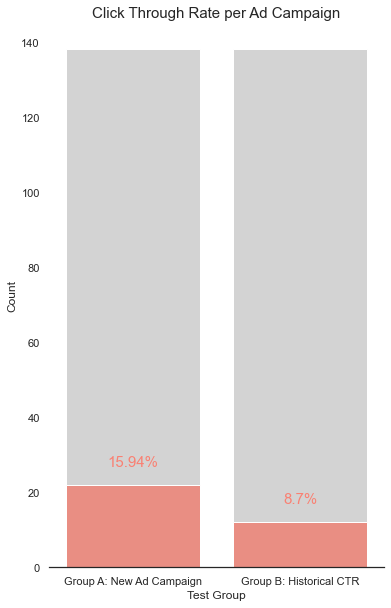

In [ ]:
# Plot stacked bars
plt.figure(figsize=(6, 10))

plot_total = sns.barplot(x=plot_data['Test Group'], 
                        y=plot_data['Total'], color='lightgrey')

plot_satisfied = sns.barplot(x=plot_data['Test Group'], 
                            y=plot_data['Click'], color=color)

# Set labels and title
plt.title('Click Through Rate per Ad Campaign', fontsize=15)
plt.ylabel('Count')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

# Put values on top of bars
row_list = []
for index, row in plot_data[plot_data['Test Group'] == 'Group A: New Ad Campaign'][['Click', 'Click Through Rate']].iterrows():
    plot_total.text(row.name, row['Click']+5, str(round(100 * row['Click Through Rate'], 2)) + '%', color=color, ha="center", fontsize=15)
for index, row in plot_data[plot_data['Test Group'] == 'Group B: Historical CTR'][['Click', 'Click Through Rate']].iterrows():
    plot_satisfied.text(row.name, row['Click']+5, str(round(100 * row['Click Through Rate'], 2)) + '%', color=color, ha="center", fontsize=15)


# Show the plot
plt.show()